In [1]:
#package imports 

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


from typing import List
import logging
import copy
import os
import sys
import gc
from functools import lru_cache
from argparse import Namespace
from packaging import version
from tqdm.autonotebook import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [3]:
# This notebook is partly adapted from the link below:
# https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

In [4]:
train_path = "emotion_data/my_train.txt"
test_path = "emotion_data/my_test.txt"
val_path = "emotion_data/my_val.txt"

In [5]:
#create a dictionary associating each string label to an integer value

labels = [ "sadness", "joy", "anger", "fear"]
label2int = dict(zip(labels, list(range(len(labels)))))

## Now we build a classifier

In [6]:
# We are going to use bert-base-uncased
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
import pandas as pd
data = pd.read_csv("emotion_data/my_train.txt",sep=";", header=None)
data1 = pd.read_csv("emotion_data/my_val.txt",sep=";", header=None)
data2 = pd.read_csv("emotion_data/my_test.txt",sep=";", header=None)
data.columns = ["text","class"]
data.head()

,text,class
0,i gotta say for the first time in a long while...,joy
1,i am pissed,anger
2,im kind of firm as the school year is coming t...,sadness
3,today im really content,joy
4,im not fine my team was disqualified and i los...,anger


In [8]:
samele_row = data.iloc[5]
sample_text = samele_row.text
# sample_text = "I have a few exercises in mind that you could really benefit from and bursh up on {a dichotomy} you may be a little hesitant and this is okay, you can trust me and yourself!"
print(sample_text)

my ex ruined my life and i am mad


In [9]:
encoding = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)
encoding.keys()
encoding["input_ids"].shape, encoding["attention_mask"].shape
# print(encoding["input_ids"].cpu().detach().numpy())
# tokenizer.decode(encoding["input_ids"].cpu().detach().numpy()[0])

(torch.Size([1, 512]), torch.Size([1, 512]))

In [10]:
encoding["input_ids"].squeeze()[:20]
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'my', 'ex', 'ruined', 'my', 'life', 'and', 'i', 'am', 'mad', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


<AxesSubplot:ylabel='Count'>

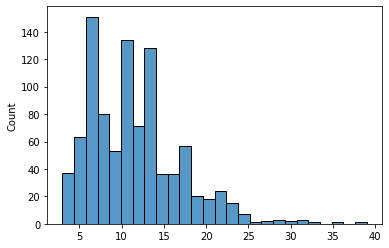

In [11]:
import seaborn as sns
token_counts = []
for _, row in data.iterrows():
    token_count = len(tokenizer.encode(
        row["text"],
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)
sns.histplot(token_counts)

In [12]:
MAX_TOKEN_COUNT = 100

## Prepare the dataset

In [13]:
class EmoDataset(Dataset):
  def __init__(
    self,
    path,
    tokenizer: BertTokenizer,
    max_token_len: int = 100
  ):
    self.tokenizer = tokenizer
    self.data_column = "text"
    self.class_column = "class"
    self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_token_len = max_token_len
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    text = data_row.text
    labels = label2int[data_row["class"]]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return (encoding["input_ids"].flatten(),encoding["attention_mask"].flatten()), torch.tensor(labels)

In [14]:
train_dataset = EmoDataset(
    train_path,
    tokenizer,
    max_token_len=100
)
sample_item = train_dataset[5]
sample_item

((tensor([ 101, 2026, 4654, 9868, 2026, 2166, 1998, 1045, 2572, 5506,  102,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0]),
  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [15]:
sample_item[1]
# sample_item["input_ids"].shape

tensor(2)

In [16]:
bert_model = BertModel.from_pretrained("bert-base-uncased")
# model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=16)))
sample_batch[0][0].shape, sample_batch[0][1].shape

(torch.Size([16, 100]), torch.Size([16, 100]))

In [18]:
output = bert_model(sample_batch[0][0], sample_batch[0][1])

In [19]:
# 768 dimension comes from the BERT hidden size
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([16, 100, 768]), torch.Size([16, 768]))

## define custom classifcation model for fine-tuning

In [20]:
#using Mish activation function 
#(from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py)
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

In [21]:
#define an EmoClassificationModel class to do the actual fine-tuning

class EmoClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_ids, attention_mask, *args):

        hidden_states = self.base_model(input_ids, attention_mask=attention_mask)
        
        return self.classifier(hidden_states[0][:, 0, :])

## prepare lightning module

In [22]:
#use PyTorch Lightning for training.
#we use PyTorch Lighning for training. Lightning methods are defined here

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoClassificationModel(BertModel.from_pretrained("bert-base-uncased"), len(labels)) #was "distilroberta-base"
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.max_token_length = 128
        self.loss = nn.CrossEntropyLoss() #cross entropy loss since this is multi-class classification
        # self.save_hyperparameters(hparams)
        self.hparams = hparams
        self.loss_amount = 0.

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(input_ids=X[0], attention_mask = X[1]), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids, attention_mask)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()

        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path, self.tokenizer, self.max_token_length),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]
   
    def save_model(self):
        torch.save(self.model.state_dict(), 'emotion_model/BERT_emotion_1ft.pt')

## begin training

In [23]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=20,
    warmup_steps=100,
    epochs=30,
    lr=2E-06,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
from pytorch_lightning.callbacks import EarlyStopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",  # monitor validation loss
    min_delta=0.001, #to very small change in the monitored quantity to qualify as an improvement
    patience=20, # used to check number of time with no improvement after which training will be stopped
    verbose=False, 
    mode="min" #sed while training will stopped when the quantity monitor has stopped decreasing
    )

In [25]:
#train (using cuda)
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches,
                     early_stop_callback=early_stop_callback)

trainer.fit(module)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
c:\Users\yisiang\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `

Epoch 29:  74%|███████▍  | 40/54 [00:10<00:03,  3.98it/s, loss=0.105, train_loss=0.104, v_num=134] 


1

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        X,y = batch_
        input_ids = X[0]
        attention_mask = X[1]
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(input_ids.to(device), attention_mask.to(device)), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))

-
________________________________________________________________________________
              precision    recall  f1-score   support

     sadness     0.8148    0.8462    0.8302        26
         joy     0.9706    1.0000    0.9851        33
       anger     0.9062    0.8286    0.8657        35
        fear     0.8846    0.9200    0.9020        25

    accuracy                         0.8992       119
   macro avg     0.8941    0.8987    0.8957       119
weighted avg     0.8996    0.8992    0.8987       119



<AxesSubplot:>

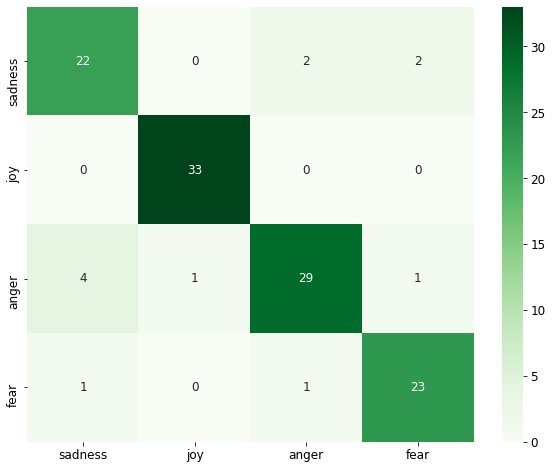

In [27]:
# plot confusion matrix
cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.rcParams.update({'font.size':12})
plt.figure(figsize=(10,8))
sns.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')

In [28]:

# save model
# module.save_model()

In [29]:
# # load model test
# hparams = Namespace(
#     train_path=train_path,
#     val_path=val_path,
#     test_path=test_path,
#     batch_size=10,
#     warmup_steps=100,
#     epochs=20,
#     lr=2.5E-05,
#     accumulate_grad_batches=1
# )
# device = torch.device('cuda:0')
# model = TrainingModule(hparams)
# model.model.load_state_dict(torch.load('empathy_model\BERT_emotion_1ft.pt'), strict=False)
# model.to(device)